In [ ]:
!apt-get install rar
!pip install pyunpack
!pip install patool

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
from numpy import asarray
from glob import glob
import numpy as np
from sklearn.preprocessing import LabelEncoder
import re
import pandas as pd 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cp "/content/drive/MyDrive/edsr_comparsion.zip" "/content/"

In [ ]:
!unrar x "/content/edsr_comparsion.zip" "/content/"

In [ ]:
%cd /content/content/

/content


In [ ]:
%rm EDSR-PyTorch/experiment/*

In [ ]:
%cd /content/content/EDSR-PyTorch/src

### Executing EDSR model to convert LR images to HR with x2 scale

In [ ]:
!python main.py

Choose which model you need: 
 [1]Edsr_baseline_x2  [2]Edsr_baseline_x3  [3]Edsr_baseline_x4  [4]Edsr_x2  [5]Edsr_x3  [6]Edsr_x4 
4
Making model...
model_weights/edsr_x2-0edfb8a3.pt
processing...


In [ ]:
%cd content/

/content


## Data preprocessing stage

In [ ]:
#/content/EDSR-PyTorch/downscaled/*
def conv_Data(path):
  a = glob(path, recursive = True)
  downscaled = []
  for i in a:
    image = Image.open(i)
    data = asarray(image)
    downscaled.append(data)
  return np.array(downscaled)

In [ ]:
downscaled = conv_Data('/content/content/EDSR-PyTorch/downscaled/*')
original = conv_Data('/content/content/EDSR-PyTorch/original/*')
hr = conv_Data('/content/content/EDSR-PyTorch/experiment/*')

In [ ]:
downscaled.shape, original.shape, hr.shape

((50000, 16, 16, 3), (50000, 32, 32, 3), (50000, 32, 32, 3))

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/trainLabels.csv')

In [ ]:
df.dtypes

id        int64
label    object
dtype: object

In [ ]:
img_number = []
a = glob('/content/content/EDSR-PyTorch/original/*', recursive = True)
for i in a:
  img_number.append(i.split('/')[-1].split('.')[0])
img_number = np.array(img_number)

In [ ]:
img_categ_class = []
for i in img_number:
  labs = df.loc[df['id'] == int(i)]
  img_categ_class.append(np.array(labs['label'])[0])
img_categ_class = np.array(img_categ_class)

In [ ]:
img_categ_class

array(['bird', 'bird', 'cat', ..., 'airplane', 'horse', 'frog'],
      dtype='<U10')

In [ ]:
labelencoder = LabelEncoder()
n_df = labelencoder.fit_transform(img_categ_class)
labels = np.array(n_df)

In [ ]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

## Performance Recovery Score Experiment

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(hr, labels, test_size=0.2, random_state=42)

In [ ]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [ ]:
cnn = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [ ]:
cnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 2304)              0         
                                                                 
 dense_10 (Dense)            (None, 64)               

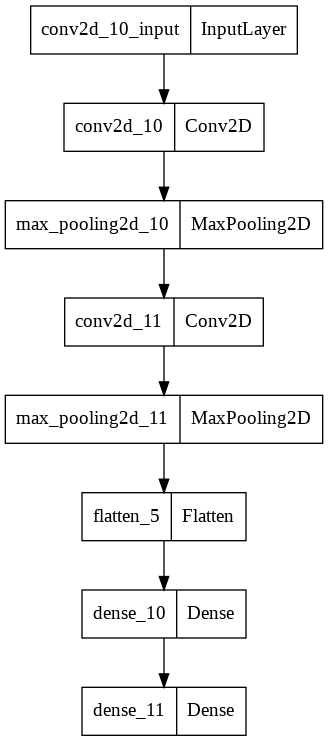

In [ ]:
tf.keras.utils.plot_model(
    cnn,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)

In [ ]:
cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = cnn.fit(X_train, y_train, epochs=10,validation_split=0.1)

Epoch 1/10
1125/1125 [==============================] - 4s 4ms/step - loss: 1.5682 - accuracy: 0.4331 - val_loss: 1.4085 - val_accuracy: 0.4988
Epoch 2/10
1125/1125 [==============================] - 4s 3ms/step - loss: 1.2263 - accuracy: 0.5660 - val_loss: 1.1579 - val_accuracy: 0.6030
Epoch 3/10
1125/1125 [==============================] - 4s 3ms/step - loss: 1.0858 - accuracy: 0.6187 - val_loss: 1.0828 - val_accuracy: 0.6173
Epoch 4/10
1125/1125 [==============================] - 5s 4ms/step - loss: 0.9885 - accuracy: 0.6541 - val_loss: 1.0467 - val_accuracy: 0.6295
Epoch 5/10
1125/1125 [==============================] - 4s 3ms/step - loss: 0.9176 - accuracy: 0.6802 - val_loss: 1.0048 - val_accuracy: 0.6490
Epoch 6/10
1125/1125 [==============================] - 4s 3ms/step - loss: 0.8605 - accuracy: 0.6955 - val_loss: 1.0278 - val_accuracy: 0.6388
Epoch 7/10
1125/1125 [==============================] - 4s 3ms/step - loss: 0.8131 - accuracy: 0.7179 - val_loss: 1.0417 - val_accuracy:

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


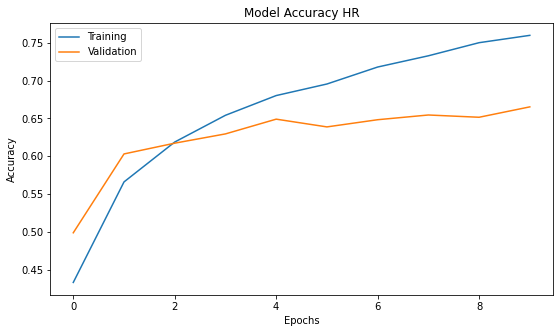

In [ ]:
plt.figure(figsize=(9,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy HR')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

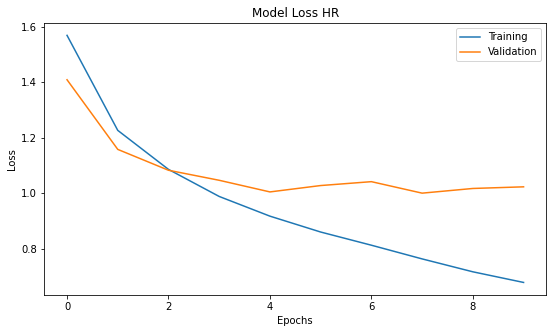

In [ ]:
plt.figure(figsize=(9,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss HR')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
cnn.evaluate(X_test,y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.9738 - accuracy: 0.6707


[0.9738052487373352, 0.6707000136375427]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(downscaled, lab, test_size=0.2, random_state=42)

In [ ]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [ ]:
cnn = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(16, 16, 3)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [ ]:
cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = cnn.fit(X_train, y_train, epochs=10,validation_split=0.1)

Epoch 1/10
1125/1125 [==============================] - 4s 3ms/step - loss: 1.7436 - accuracy: 0.3576 - val_loss: 1.5995 - val_accuracy: 0.4178
Epoch 2/10
1125/1125 [==============================] - 3s 3ms/step - loss: 1.4817 - accuracy: 0.4647 - val_loss: 1.4939 - val_accuracy: 0.4645
Epoch 3/10
1125/1125 [==============================] - 3s 3ms/step - loss: 1.3821 - accuracy: 0.5010 - val_loss: 1.3602 - val_accuracy: 0.5247
Epoch 4/10
1125/1125 [==============================] - 4s 3ms/step - loss: 1.3065 - accuracy: 0.5325 - val_loss: 1.3332 - val_accuracy: 0.5222
Epoch 5/10
1125/1125 [==============================] - 4s 4ms/step - loss: 1.2489 - accuracy: 0.5529 - val_loss: 1.3774 - val_accuracy: 0.5155
Epoch 6/10
1125/1125 [==============================] - 4s 3ms/step - loss: 1.2031 - accuracy: 0.5718 - val_loss: 1.2688 - val_accuracy: 0.5508
Epoch 7/10
1125/1125 [==============================] - 3s 3ms/step - loss: 1.1642 - accuracy: 0.5867 - val_loss: 1.2364 - val_accuracy:

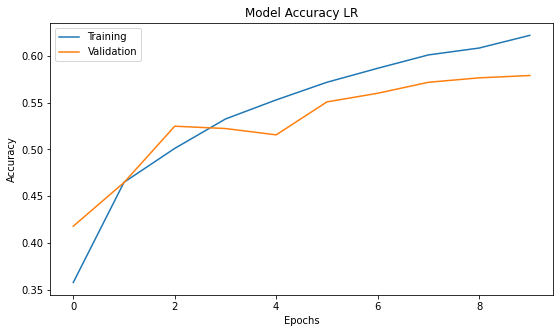

In [ ]:
plt.figure(figsize=(9,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy LR')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

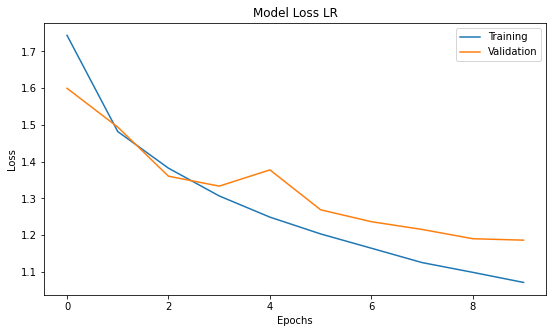

In [ ]:
plt.figure(figsize=(9,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss LR')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
cnn.evaluate(X_test,y_test)

313/313 [==============================] - 1s 3ms/step - loss: 1.1576 - accuracy: 0.6000


[1.1576499938964844, 0.6000000238418579]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(original, lab, test_size=0.2, random_state=42)

In [ ]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [ ]:
history = cnn.fit(X_train, y_train, epochs=10,validation_split=0.1)

Epoch 1/10
1125/1125 [==============================] - 5s 4ms/step - loss: 1.5624 - accuracy: 0.4357 - val_loss: 1.2737 - val_accuracy: 0.5412
Epoch 2/10
1125/1125 [==============================] - 4s 3ms/step - loss: 1.1928 - accuracy: 0.5799 - val_loss: 1.1283 - val_accuracy: 0.6020
Epoch 3/10
1125/1125 [==============================] - 4s 3ms/step - loss: 1.0526 - accuracy: 0.6332 - val_loss: 1.0703 - val_accuracy: 0.6155
Epoch 4/10
1125/1125 [==============================] - 4s 3ms/step - loss: 0.9634 - accuracy: 0.6648 - val_loss: 1.0604 - val_accuracy: 0.6310
Epoch 5/10
1125/1125 [==============================] - 4s 3ms/step - loss: 0.8903 - accuracy: 0.6902 - val_loss: 0.9815 - val_accuracy: 0.6595
Epoch 6/10
1125/1125 [==============================] - 4s 3ms/step - loss: 0.8314 - accuracy: 0.7130 - val_loss: 0.9646 - val_accuracy: 0.6690
Epoch 7/10
1125/1125 [==============================] - 4s 3ms/step - loss: 0.7790 - accuracy: 0.7307 - val_loss: 0.9814 - val_accuracy:

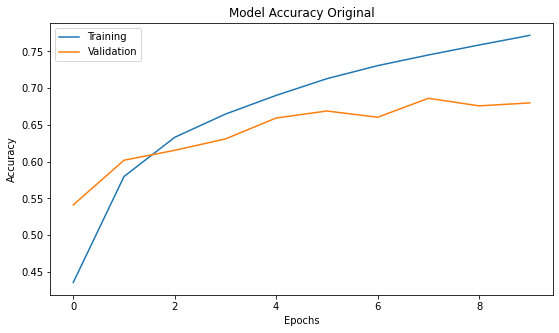

In [ ]:
plt.figure(figsize=(9,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Original')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

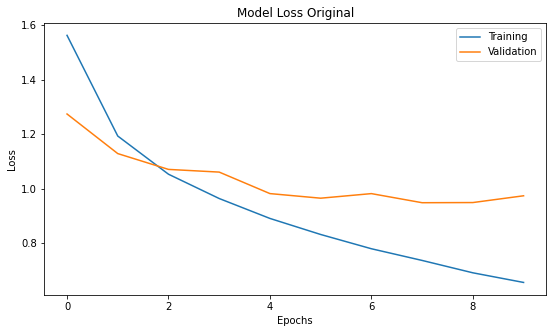

In [ ]:
plt.figure(figsize=(9,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss Original')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
cnn.evaluate(X_test,y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.9595 - accuracy: 0.6799


[0.9594609141349792, 0.6798999905586243]

In [ ]:
0.6707000136375427 / 0.6798999905586243

0.9864686320799584